In [0]:
#Priya Rajpurohit 2015073
#Sakshi Saini 2017092

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3

from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

from keras.models import Model
from keras.utils import np_utils
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive1 = GoogleDrive(gauth)


In [0]:
link = 'https://drive.google.com/open?id=10fFInHmGZ5PsbMTRb_7EuhJcGNHisjCi'
fluff, id = link.split('=')
print (id) 

10fFInHmGZ5PsbMTRb_7EuhJcGNHisjCi


In [0]:
downloaded = drive1.CreateFile({'id':id}) 
downloaded.GetContentFile('Segmented.zip')

In [0]:
from zipfile import ZipFile

with ZipFile('/content/Segmented.zip', 'r') as zipObj:
   zipObj.extractall()


In [0]:
path = '/content/Segmented/'
images=[]
labels=[]

lable = 1
for r, d, f in os.walk(path):
    for folder in d:       
        for r1, d1, f1 in os.walk(os.path.join(r, folder)):
          for file in f1:
            images.append( cv2.imread(os.path.join(r1, file) ))
            labels.append(lable)
          lable = lable +1

images = np.array(images)

In [0]:
X_train, X_test, y_train, y_test = train_test_split( images[:20000], labels[:20000], test_size=0.3, random_state=42 , shuffle=True)
print(X_train.shape, X_test.shape)

(14000, 256, 256, 3) (6000, 256, 256, 3)


In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False)


87916544/87910968 [==============================] - 1s 0us/step


In [0]:
n = 38
x = base_model.output

x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(n, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
y_train = np_utils.to_categorical( y_train, n)
y_test = np_utils.to_categorical( y_test, n)

In [0]:
EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(
      X_train, y_train,
      epochs = EPOCHS,
      # steps_per_epoch = STEPS_PER_EPOCH,
      validation_data = (X_test, y_test ),
      # validation_steps = VALIDATION_STEPS,
      batch_size= 50,
      shuffle=True,
      verbose=1
    )

Train on 14000 samples, validate on 6000 samples
Epoch 1/20
14000/14000 [==============================] - 1129s 81ms/step - loss: 0.4131 - accuracy: 0.8806 - val_loss: 910.7920 - val_accuracy: 0.2710
Epoch 2/20
14000/14000 [==============================] - 1029s 74ms/step - loss: 0.1459 - accuracy: 0.9541 - val_loss: 1.0890 - val_accuracy: 0.8392
Epoch 3/20
14000/14000 [==============================] - 1045s 75ms/step - loss: 0.0947 - accuracy: 0.9694 - val_loss: 0.5580 - val_accuracy: 0.8967
Epoch 4/20
14000/14000 [==============================] - 1033s 74ms/step - loss: 0.0857 - accuracy: 0.9739 - val_loss: 1.4495 - val_accuracy: 0.8072
Epoch 5/20
14000/14000 [==============================] - 1012s 72ms/step - loss: 0.0601 - accuracy: 0.9808 - val_loss: 0.1874 - val_accuracy: 0.9505
Epoch 6/20
14000/14000 [==============================] - 1018s 73ms/step - loss: 0.0650 - accuracy: 0.9801 - val_loss: 0.6512 - val_accuracy: 0.9362
Epoch 7/20
14000/14000 [=========================

In [0]:
MODEL_FILE = 'inceptionV3Seg.model'
model.save(MODEL_FILE)

In [0]:
final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))


FINAL ACCURACY MEAN-5:  0.9169333338737488


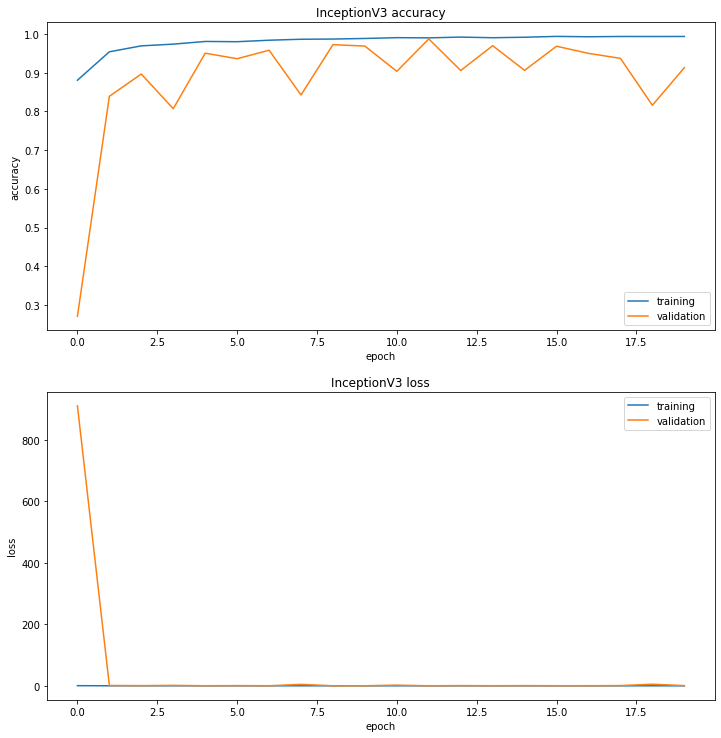

In [0]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('InceptionV3 '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [0]:
from keras.applications.inception_v3 import preprocess_input

In [0]:
model = InceptionV3(weights='imagenet', include_top=False)

fetaureX = []

for image in X_train:

  image = cv2.resize(image, (224, 224))

  image = np.expand_dims( image, axis=0)
  image = preprocess_input(image)
  feature = model.predict(image)

  fetaureX.append(feature)

In [0]:
fetaureXt = []

for image in X_test:

  image = cv2.resize(image, (224, 224))

  image = np.expand_dims(image, axis=0)
  image = preprocess_input(image)
  feature = model.predict(image)

  fetaureXt.append(feature)

In [0]:
from sklearn.ensemble import RandomForestClassifier

fetaureX = np.array(fetaureX)
fetaureX = fetaureX.reshape(14000, 51200)

clf = RandomForestClassifier()
clf.fit(fetaureX,  y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
featuresTest = np.array(fetaureXt)

featuresTest = featuresTest.reshape(6000, 51200)

accuracy = clf.score(featuresTest,y_test)
accuracy *= 100
print(accuracy)


82.15


In [0]:
import h5py


h5_data    = 'segmented_iception.h5'
h5_labels  = 'labels_inception_seg.h5'

h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(fetaureX))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(y_train))

<HDF5 dataset "dataset_1": shape (14000,), type "<i8">

In [0]:
import h5py


h5_data    = 'segmented_iceptiontest.h5'
h5_labels  = 'labels_inception_segtest.h5'

h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(featuresTest))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(y_test))

<HDF5 dataset "dataset_1": shape (6000,), type "<i8">

In [0]:
from sklearn import svm

featuresTrain = np.array(fetaureX)
featuresTrain = featuresTrain.reshape(14000, 51200)

clf1 = svm.SVC()
clf1.fit(featuresTrain,  y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
featuresTest = np.array(fetaureXt)

featuresTest = featuresTest.reshape(6000, 51200)

accuracy = clf1.score(featuresTest,y_test)
accuracy *= 100
print(accuracy)

In [0]:
filename = 'finalized_model.sav'
pickle.dump(clf1, open(filename, 'wb'))


6000

In [0]:
2048*5*5

51200